In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random

In [17]:
path = ''

In [18]:
fire_paths = []
for img_path in glob.glob(path + 'Training/Fire/*.*'):
    fire_paths.append(img_path)

In [19]:
fire_imgs = []
for img_path in random.sample(fire_paths, 9):
    fire_imgs.append(cv2.imread(img_path))

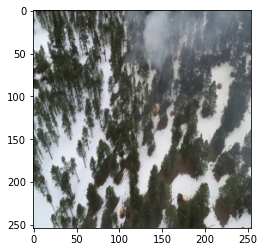

In [36]:
image = fire_imgs[1]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [37]:
# (Blue, Green, Red)
lower_bound = (0, 0, 125)
upper_bound = (100, 200, 255)

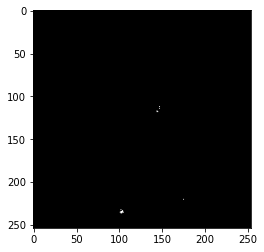

In [38]:
mask = cv2.inRange(image, lower_bound, upper_bound)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [39]:
contours, hier = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

contours_poly = list(range(len(contours)))

In [44]:
def RemoveSmallRects(bounds, min_area):
    small_rects = []
    
    for rect in bounds:
        if (rect[2]*rect[3] < min_area):
            small_rects.append(rect)
    
    for rect in small_rects:
        bounds.remove(rect)
    
    return bounds

def GetCenter(rect):
    x, y, w, h = rect
    
    x_center = (x + w/2)
    y_center = (y + h/2)
    
    return x_center, y_center

def CalculateDistance(first_rect, second_rect):
    x1, y1 = GetCenter(first_rect)
    x2, y2 = GetCenter(second_rect)
    
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distance

def CombineRects(first_rect, second_rect):
    x_min = min(first_rect[0], second_rect[0])
    y_min = min(first_rect[1], second_rect[1])
    
    x_max = max(first_rect[0], second_rect[0])
    y_max = max(first_rect[1], second_rect[1])
            
    new_w = x_max - x_min
    new_h = y_max - y_min
            
    newRect = (x_min, y_min, new_w, new_h)
    
    return newRect

def CombineClosestRects(bounds, min_distance):
    
    smallest_dist = np.Infinity
    
    while(True):
        
        closest_rect = []
        
        for i in range(1, len(bounds)):
            smallest_dist = min(smallest_dist,
                               CalculateDistance(bounds[i], bounds[i-1]))
        
        for j in range(1, len(bounds)):
            if (CalculateDistance(bounds[i], bounds[i-1]) <= min_distance):
                closest_rect = [bounds[j], bounds[j-1]]
        
        if (closest_rect != []):
            for rect in closest_rect:
                bounds.remove(rect)
            
            newRect = CombineRects(closest_rect[0], closest_rect[1])
            bounds.append(newRect)
        else:
            break
    
    return bounds
            
    
def EnlargeRects(bounds, amount):

    new_bounds = []

    for rect in bounds:
        new_x = rect[0] - amount
        new_y = rect[1] - amount
        new_w = rect[2] + amount
        new_h = rect[3] + amount
        
        new_rect = (new_x, new_y, new_w, new_h)
        new_bounds.append(new_rect)
    
    return new_bounds

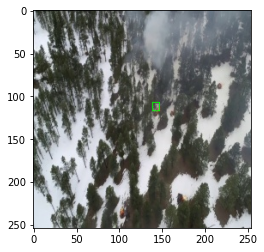

In [41]:
boundRects = []
image_copy = image.copy()

for i, c in enumerate(contours):

    if hier[0][i][3] == -1:
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRects.append(cv2.boundingRect(contours_poly[i]))

CombineClosestRects(boundRects, 25)
boundRects = RemoveSmallRects(boundRects, 10)
boundRects = EnlargeRects(boundRects, 5)
        
# For Visualization
for i in range(len(boundRects)):
    color = (0, 255, 0)
    cv2.rectangle(image_copy, (int(boundRects[i][0]), int(boundRects[i][1])), 
              (int(boundRects[i][0] + boundRects[i][2]), int(boundRects[i][1] + boundRects[i][3])), color, 1)
    
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

<Figure size 432x288 with 0 Axes>

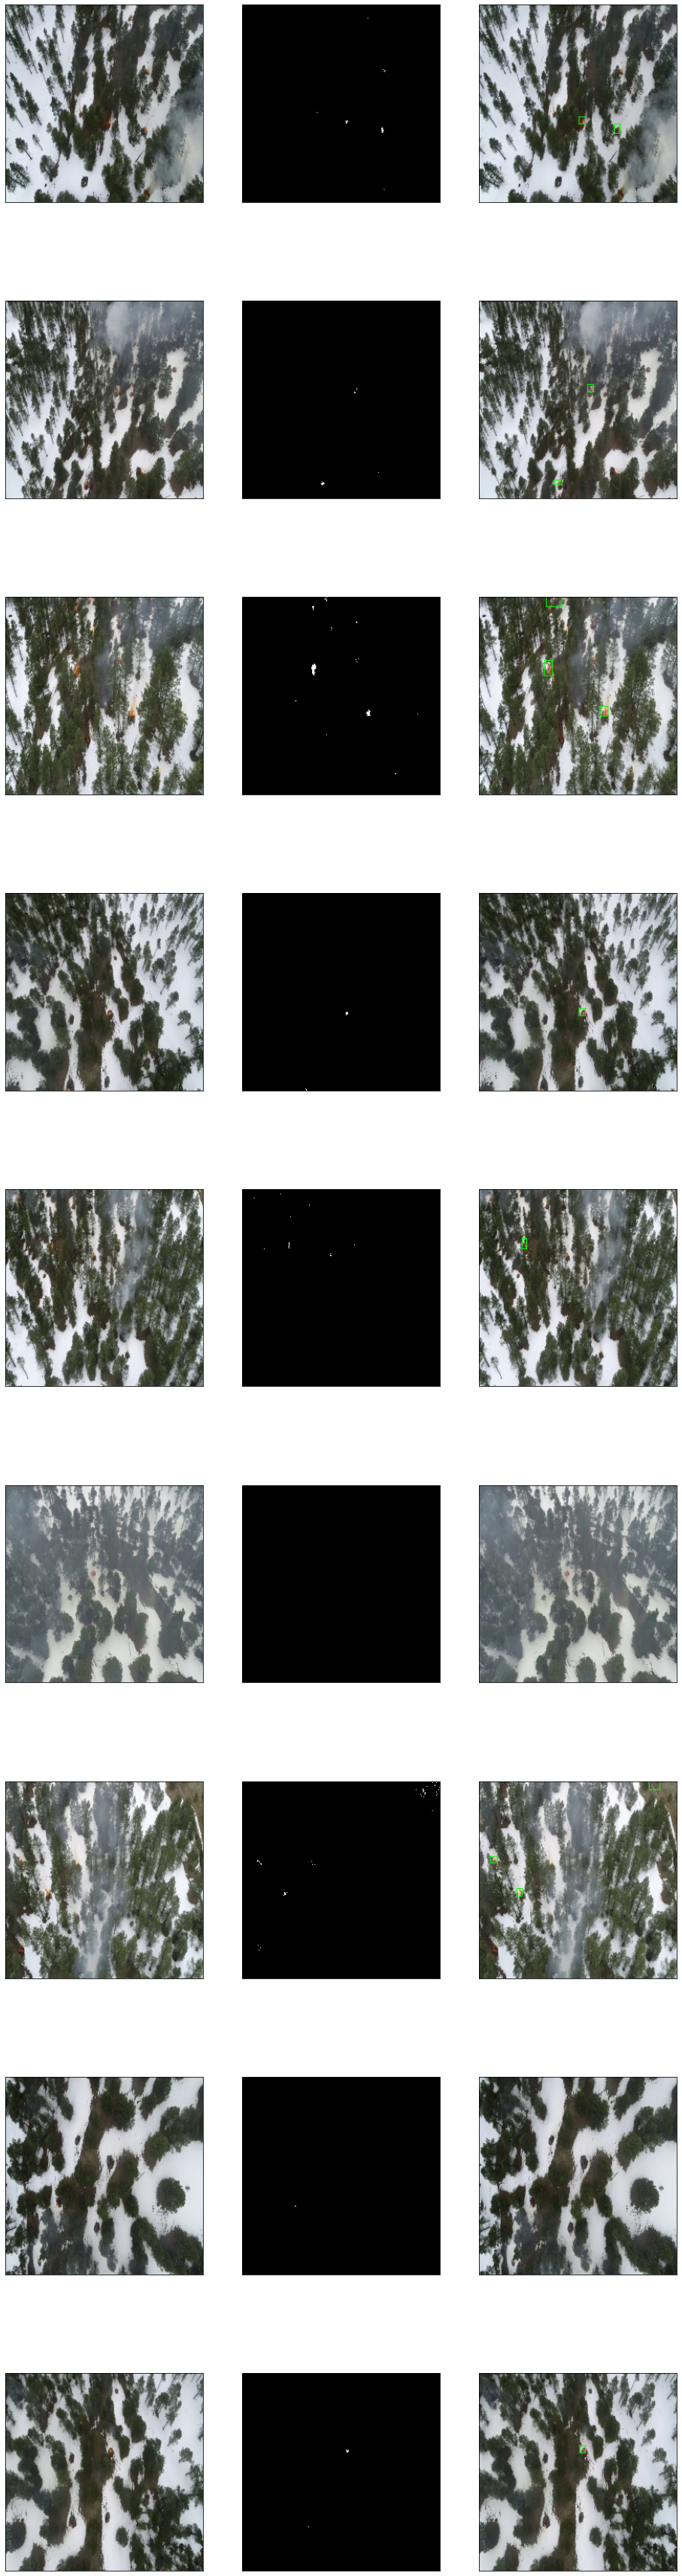

In [45]:
fire_imgs_copies = []
fire_masks = []

for img in fire_imgs:
    mask = cv2.inRange(img, lower_bound, upper_bound)
    
    contours, hier = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_poly = list(range(len(contours)))
    
    boundRects = []
    image_copy = img.copy()
    
    for i, c in enumerate(contours):
    
        if hier[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRects.append(cv2.boundingRect(contours_poly[i]))
    
    boundRects = CombineClosestRects(boundRects, 25)
    boundRects = RemoveSmallRects(boundRects, 5)
    boundRects = EnlargeRects(boundRects, 5)
    
    # For Visualization
    for i in range(len(boundRects)):
        color = (0, 255, 0)
        cv2.rectangle(image_copy, (int(boundRects[i][0]), int(boundRects[i][1])), 
                  (int(boundRects[i][0] + boundRects[i][2]), int(boundRects[i][1] + boundRects[i][3])), color, 1)
    
    fire_imgs_copies.append(image_copy)
    fire_masks.append(mask)

plt.figure()

ncols = 3
nrows = len(fire_imgs)

fig, axes = plt.subplots(nrows, ncols, figsize = (16, 64))
index = 0

num_subplots = ncols*nrows

for i in range(num_subplots):

    plt.subplot(nrows, ncols, i + 1)
    if (i % 3 == 0):
        plot = fire_imgs[index]
    elif (i % 3 == 1):
        plot = fire_masks[index]
    elif (i % 3 == 2):
        plot = fire_imgs_copies[index]
        index += 1
    
    plt.imshow(cv2.cvtColor(plot, cv2.COLOR_BGR2RGB))
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

    
plt.show()

## 

In [ ]:
todo = [5437, 15442, 4019, 1130, 9281, 24195, 25113, 9233, 12598, 2448, 25466, 12024, 13683, 20056, 20243, 19769, 9553, 3639, 6585, 5860, 18845, 4, 14414, 27275, 9619, 21543, 4765, 6302, 12321, 363, 8225, 1447, 16757, 8454, 17062, 10568, 21687, 6130, 22315, 13692, 5386, 27060, 10264, 25738, 11315, 19246, 26615, 13883, 16918, 16805, 20053, 9593, 7798, 11862, 18986, 5901, 11526, 26157, 9856, 18697, 18999, 22685, 9747, 15755, 19614, 8096, 12961, 9359, 23080, 23924, 9065, 26834, 22286, 20551, 872, 3031, 15126, 2510, 15332, 18811, 20524, 25327, 20248, 23171, 14775, 1715, 7883, 4644, 10976, 15424, 14927, 22434, 14618, 13910, 14617, 21588, 20850, 20690, 16335, 15503, 7636, 24220, 24571, 10959, 15463, 20730, 22519, 15656, 8685, 27460, 20202, 8836, 26317, 20176, 17041, 18101, 15910, 19789, 16044, 17786, 5285, 14591, 4231, 16682, 13892, 2952, 18516, 23007, 15926, 2622, 21299, 13846, 2168, 8714, 9541, 938, 6781, 6951, 25298, 14215, 5668, 21631, 18832, 16133, 21519, 18117, 16330, 8181, 9675, 5926, 6109, 13480, 17906, 23664, 2241, 7250, 20475, 18454, 10523, 15901, 16219, 10309, 16218, 4844, 6833, 7128, 4513, 3262, 6145, 12152, 10036, 27309, 4726, 179, 26731, 13580, 20607, 19010, 24371, 6034, 12716, 26601, 23916, 17428, 8284, 5830, 17509, 20474, 26005, 12502, 1225, 5289, 22085, 4904, 2163, 6667, 13937, 23078, 25581, 16788, 20435, 6812, 15074, 17238, 25651, 21151, 5026, 20979, 23025, 12878, 19075, 20424, 16878, 18490, 20249, 12629, 5062, 4216, 3667, 17584, 11045, 10562, 11406, 17102, 12384, 24437, 7050, 18102, 4901, 16892, 24537, 16203, 24481, 22122, 11342, 22311, 16168, 15835, 11931, 5283, 6460, 12374, 3309, 23410, 6794, 14499, 16939, 19334, 7887, 20570, 17976, 12202, 16969, 652, 24979, 22741, 14083, 5832, 13496, 5166, 14884, 14287, 19469, 16941, 23808, 11511, 27182, 11814, 1783, 21568, 466, 14623, 7039, 16612, 22065, 13708, 10435, 13442, 19901, 16082, 24329, 19445, 21646, 4738, 665, 22215, 21808, 24974, 13405, 26340, 2469, 11750, 22046, 20562, 14346, 5049, 15688, 2468, 24224, 20935, 7078, 3408, 6660, 7608, 4351, 21859, 8061, 22047, 26120, 21037, 17161, 17423, 3202, 14073, 25155, 11654, 21894, 22276, 21371, 7071, 19425, 22835, 27318, 10727, 15072, 4915, 15515, 5543, 15461, 15587, 6014, 5153, 24695, 20722, 12622, 17431, 318, 2924, 9715, 5314, 6774, 13776, 1865, 6536, 2996, 26883, 10676, 7951, 492, 12563, 14743, 11590, 11885, 4444, 21302, 22587, 12456, 17027, 212, 17183, 8448, 20663, 15008, 18187, 10101, 23996, 10887, 13877, 26197, 20266, 16030, 23440, 11548, 17999, 489, 989, 14304, 26465, 6365, 6741, 21201, 17722, 24518, 4383, 24400, 11942, 6612, 19344, 4281, 17800, 25541, 19648, 10411, 21775, 9334, 24239, 9193, 5533, 2613, 10785, 6932, 5248, 13768, 10273, 3895, 7710, 17860, 20224, 404, 26662, 4870, 4643, 20270, 20064, 22297, 14089, 13257, 3242, 10947, 10012, 3508, 6198, 13536, 14227, 8596, 7616, 16389, 18630, 19175, 23942, 20654, 8439, 13600, 26740, 13921, 4620, 23918, 21074, 22599, 26401, 25357, 18502, 24970, 22407, 18416, 20993, 18964, 16119, 16826, 25955, 10754, 15416, 13958, 7396, 3758, 26617, 11139, 13890, 25691, 18870, 13363, 16197, 5807, 7027, 15032, 18035, 13841, 13895, 1190, 17426, 23184, 22152, 24574, 11643, 13520, 15087, 9202, 13079, 13103, 8023, 17534, 9500, 2751, 20156, 10379, 23982, 8873, 5685, 16095, 22461, 8288, 17535, 3191, 26880, 1738, 3403, 27522, 12815, 3993, 19162]

In [ ]:
todo_dict = dict()
todo_set = set(todo)

for img_path in glob.glob(path + 'Training/Fire/*.*'):
    img_id = int(img_path.split('frame')[1].split('.')[0])
    if (img_id in todo_set):
        todo_dict[img_id] = cv2.imread(img_path)